# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract

import time
import random

from memory_profiler import profile

import FalseWordGenerator as FWG

import ALPHABET_8
ALPHABET = ALPHABET_8.ALPHABET
print (ALPHABET)

['a', 'e', 'i', 'n', 'o', 'r', 's', 't']


In [2]:
MEANINGFUL_WORDS = ALPHABET_8.WORDS
MEANINGLESS_WORDS = FWG.generateFalseWords(ALPHABET, MEANINGFUL_WORDS)
def target(w):             
   if w.lower() in MEANINGFUL_WORDS:
      return True
   else:
      return False
    
train_set = {}
train_set.update({w: True for w in MEANINGFUL_WORDS})
train_set.update({w: False for w in MEANINGLESS_WORDS})
print ("made training set of size: " + str(len(train_set)))
print ("of which " + str(len(MEANINGFUL_WORDS)) + str(" are positive"))
print ("of which " + str(len(MEANINGLESS_WORDS)) + str(" are negative"))

made training set of size: 2034
of which 1031 are positive
of which 1008 are negative


# Train and Extract with the optimal network

In [3]:
rnnOpt = RNNClassifier(ALPHABET,num_layers=3,hidden_dim=50,RNNClass = LSTMNetwork)

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


current average loss is:  0.320195057779467
current average loss is:  0.1453725626780873
current average loss is:  0.015074508703199308


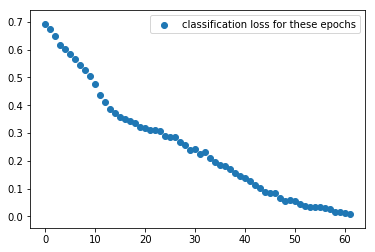

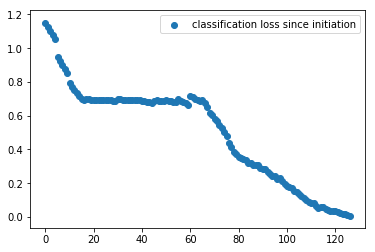

classification loss on last batch was: 0.008627381524529586


In [4]:
mixed_curriculum_train(rnnOpt,train_set,stop_threshold = 0.01)

In [5]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnOpt.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnOpt.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [6]:
rnnOpt.renew()

In [7]:
dfaOpt = extract(rnnOpt,time_limit = 120, initial_split_depth = 10, starting_examples = starting_examples)

provided counterexamples are: ['an', 'ri']
obs table refinement took 0.001
guided starting equivalence query for DFA of size 2
['', 'a']
refining, H size is 1
split wasn't perfect: gotta start over
['n', 's']
refining, H size is 1
['aa', 'ao']
refining, H size is 1
returning counterexample of length 2:		ea, this counterexample is rejected by the given RNN.
equivalence checking took: 0.5964249980000034
obs table refinement took 0.042
guided starting equivalence query for DFA of size 8
['ea', 'eo']
returning counterexample of length 5:		eoato, this counterexample is rejected by the given RNN.
equivalence checking took: 0.023184829999991052
obs table refinement took 0.439
guided starting equivalence query for DFA of size 28
['ea', 'eo']
returning counterexample of length 5:		eosir, this counterexample is rejected by the given RNN.
equivalence checking took: 0.024154664000008097
obs table refinement took 1.241
guided starting equivalence query for DFA of size 51
['ea', 'eo']
returning coun

# Cypher some messages

In [8]:
from MessageMaker import makeMessage

messageLength = 5

messages = []
for i in range (1000):
    messages.append(makeMessage(MEANINGFUL_WORDS, messageLength))

In [9]:
import cypher_creation as c

rotationCypheredMessages = []
for message in messages:
    rotationCypheredMessages.append(c.rotate_sentence(message, ALPHABET))
    
swappedCypherMessages = []
for message in messages:
    swappedCypherMessages.append(c.swap_letters(message, ALPHABET)[0])

# Attempt to crack the rotation cyphers

In [10]:
import Rotation_Checker as RCT

preCountRNN = 0.0
accCountRNN = 0.0  
hitRateRNN = 0.0
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    rnnReport = RCT.checkRtCy(rotationCypheredMessages[index], ALPHABET, rnnOpt)
    message = messages[index]
    preCountRNN += float(rnnReport[0])
    if message in rnnReport[1]:
        accCountRNN += 1 / len(rnnReport[1])
        hitRateRNN += 1

accuracyRNN = accCountRNN / len(rotationCypheredMessages)
precisionRNN = preCountRNN / len(rotationCypheredMessages)
hitRateRNN = hitRateRNN / len(rotationCypheredMessages)
rnnRunTime = time.time() - startTime
print ('accuracy of RNN: ', accuracyRNN)#how many answer were correct out of the the returned answers
print ('precision of RNN: ',precisionRNN)#how likely this is to be the decrypted message
print ('hitRate of DFA: ', hitRateRNN)#how often the correct answer was returned
print ('runtime of RNN: ',rnnRunTime)
print("\n")


preCountDFA = 0.0
accCountDFA = 0.0 
hitRateDFA = 0.0
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    rnnReport = RCT.checkRtCy(rotationCypheredMessages[index], ALPHABET, dfaOpt)
    message = messages[index]
    preCountDFA += float(rnnReport[0])
    if message in rnnReport[1]:
        accCountDFA += 1 / len(rnnReport[1])
        hitRateDFA += 1
accuracyDFA = accCountDFA / len(rotationCypheredMessages)#how many answer were correct out of the the returned answers
precisionDFA = preCountDFA / len(rotationCypheredMessages)#how likely this is to be the decrypted message
hitRateDFA = hitRateDFA / len(rotationCypheredMessages)#how often the correct answer was returned
dfaRunTime = time.time() - startTime
print ('accuracy of DFA: ', accuracyDFA)
print ('precision of DFA: ',precisionDFA)
print ('hitRate of DFA: ', hitRateDFA)
print ('runtime of DFA: ',dfaRunTime)

print("\n")
import BruteForce as BF
accCountBF = 0.0 
hitRateBF = 0.0
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    bfReport = BF.checkInList(rotationCypheredMessages[index])
    message = messages[index].split()
    if message in bfReport:
        accCountBF += 1/ len(bfReport)
        hitRateBF += 1
bfRunTime = time.time() - startTime
accuracyBF = accCountBF / len(rotationCypheredMessages)
hitRateBF = hitRateBF / len(rotationCypheredMessages)
print ('accuracy of BF: ', accuracyBF)
print ('hitRate of BF: ', hitRateBF)
print ('runtime of BF: ',bfRunTime)

accuracy of RNN:  0.25289285714285586
precision of RNN:  0.9971999999999999
hitRate of DFA:  0.986
runtime of RNN:  12.436065435409546


accuracy of DFA:  0.06351904761904771
precision of DFA:  0.7565999999999989
hitRate of DFA:  0.242
runtime of DFA:  0.1874556541442871


accuracy of BF:  1.0
hitRate of BF:  1.0
runtime of BF:  0.08180570602416992


# Attempt to crack the swap cyphers

In [11]:
import frequencyAnalysis as fa

from collections import Counter
SENTENCE="eat is ir tae ate"
output = fa.freqAnalysisSwap(MEANINGFUL_WORDS, SENTENCE)
print (output)

('ten sr sa net ent ', {'e': 't', 'a': 'e', 't': 'n', 'i': 's', 's': 'r', 'r': 'a'})


In [12]:
#Call draw_nicely to hijack the dfa
dfaOpt.draw_nicely(maximum=300)

for index in range(len(swappedCypherMessages)):
    cypherMessage = swappedCypherMessages[index]
    message = messages[index]
    decypheredMessage = ""
    for word in cypherMessage.split():
        actualWord = dfaOpt.wordsWithWordnessScore(list(word))
        decypheredMessage += " " +"".join(actualWord)
    print(message)
    print(decypheredMessage)

 treason etonian teat arietta tinner
 ritsttt ttotirt otso stitots tittto
 terrain sister trainer rastas rase
 tsosttt ttotts orrsots stosto stot
 tate neon enate testosterone senorita
 tstt ritt tostt ttotttostrtt rirtttrs
 tit annon terrine aries atresia
 tto ersts iaittot ttott ttottto
 rottenness satire reseat initiate tarantino
 tssiotttot ttittt ttottt totttoto stoseints
 satinet striation sonata erato soreness
 tittstt ittonttts tssnon ttnoo tstteott
 stentorian te toitoi ass naris
 orrntsetis tt retttt tto stoto
 toot insistent sene eonian stator
 ttot ttotttitt tstt totost tssott
 ionate rot artiste sennit irena
 ttostt tto stotitt ttottt tstts
 innate satin asian orientation arere
 ttottt ttitt tottt ortttnonooo ttott
 attrition oto eisenstein sestet astasia
 ttottrist tto ritisttstt trosst ttottst
 rooter nation tine nasion sinai
 tottto trosot tstt trisot totst
 sanitise retention iritis troat retina
 ttotttot ttittitst tstttt tssot ttittt
 tat sarasota nester tennis osiris

 ternate ease terrorise seats sanitate
 tatottt ttot toststtoo tsttt etetstto
 tinter iranian treasonist aerie nosiness
 ttotts orotttt tstttttttt tssot ttotttot
 sinner steiner erin reset astatine
 trotot tsosttt ttot tsttt ttnonooo
 tatar toetoe snorter attester anisette
 ttott tsrott ttottto roortttt itsotott
 nero note snare earn interne
 ttot tstt sstot ttot tsttttt
 tara tine aries tintoretto oration
 ttno ttot ttots orsnsisott settttt
 ranter rente ensis ratter saarinen
 orttto ontrt ttott snosto orsrnttt
 trot rastas sit tenor insistent
 tssn trosto ttn ttost ttotttott
 reseat nitre asia orissa nattiness
 tstott stoss ttit ttnooo tattnoooo
 resonate terseness striate serotine sit
 ttosstrt ettstitoo tstottt ttottstt tst
 artiste entire estrone nisan tennessean
 esttost tiotst ritsttt ttott atnirttttt
 tire rotate retain senora steatornis
 ttot tstttt ttittt tstett ritttstttt
 aten sanitariness ans sent notation
 ttot ttortstsoott tst ttot tstsitso
 snootiness retrorse tartness 

 saree neaten assonate nattiness nearer
 arsot satttt stotoott orstttttt satsts
 insatiate tinea son rostrate otoe
 tistttttt ttnoo stn etottoto ttot
 artist orasone stare astana sonatina
 ssotit stesttt atnot irtnon rotttttt
 soonest stainer astana reentrant inert
 ontrtto totottt ttottt totttnooo sstno
 insist aster antenna sestet nenets
 tstttt tottt eattssn stosto etottt
 orris ensete sitter toronto root
 tortt tstttt ttottt tsttttt ttot
 terrietia insaneness restraint anti noon
 tisstisto ttotttottt rissrtttt tott ttot
 ton tantra interne sison sootiness
 tto ttottt tsttttt orstt onnotttss
 on ratio tea eastern tarsier
 tt ottno ott onstttt ttostto
 anisette intonation tisane internee so
 stotottt ttottstttt totstt nnooonoo tt
 resister strainer interest oneness rat
 itorottt stnoooon rittttst sototss tst
 an tenant sine noon tartar
 tt ittost stot otto ttittt
 ionian saree airiness intestine taro
 ttittt stoto ttortsis tsttottto ttot
 instantiate tease stetson astir toss
 ritstto

 tortoise treater intonate sian isatis
 stostott totottt eattottt ttos ttottt
 steen raisin sienna tartarean stoat
 sottt titsto ottotn rettttttt stost
 roost nearer astir aortitis eater
 ttott stotit ontrt notrsttt tottt
 tsaritsa trite trenton toon titter
 tssittts tsttt nittstt otto ttottt
 terrasse stain inter tera siriasis
 tsostttt ttott totts tsso tssnoono
 saone anti initiate stir astern
 totst tott ortttooo itto nittss
 nentsi arteria sear tent treater
 ttotts stotiso ttot ttot tittstt
 rose attire sin stone tattoo
 stot oasost ttn ttott tottto
 art retina sterninae easter eon
 tto trostn etretttts settst sst
 stare root taster sire toronto
 sottt ttot onsttt stot rottttt
 serer error orasone ness sine
 ttnon ttitt titttot ttot tstt
 titrator store stirrer entire iterate
 titottot stost settttt setttt erenttt
 assassin snore inosine nosiness easter
 orresttt ttott storttt rotttttt tstttt
 tertian or soiree ranter attorn
 tsttsot tt tsottt ttottt rotttt
 stasis interior ernst s

 retreatant rattan trotter satire rostrate
 nittsottso onstts ttottto ontton stoitttt
 taoist intense aerie stet entrant
 tstttt tioontt stost tstt ttotsto
 aton rotate tinea sennett sars
 stot atosst ttits atnitot tstt
 testosterone inner tar tasse store
 irrotootsott ttots tos ttott ttost
 attester set notate straiten seta
 ttnoonoo ttn tstttt tatrttot ttno
 sierra torreon asset intro titaness
 ttnooo ttostrs ttott tsttt sattsttt
 essen sortie roister teens tease
 rotst ttitts ittosst orstt artss
 ratter tea aranea astatine etonian
 ritttt ttn ttittt ttosostt ttotsst
 trainer taira rosin otiose tears
 ttistto tssot totst tseott ttnoo
 stain iritis reasoner seine troat
 rittt ttottt ttosottt ttott itsot
 rotate ionia intestine easiness annona
 tartst orttt tatottott tettottt ertstt
 eira instant inanna snorter anatotitan
 ttot trotiso tstost snoottt tsttotttis
 rein tinea stirrer retro stentor
 tost tsttt arstitn ettst tsttttt
 snootiness orites rosette tertian anna
 tottottstt tittst

 stein testiere ensete aesir torreon
 tsttt ttoesttt rotttt ttott snosost
 statant restraint toter ariose sterne
 totottt tattoonoo ttost triots tseots
 sorter sonsie at ate ononis
 rotttt rotsit tt tot ttotts
 sonnet tenia inset stir orissa
 netttt tsttt itott stno otisso
 senor striation roister tontine area
 orttt ttnoooooo ttottst oarttts tsso
 ant anti torreon satin sitta
 ttn ttno trortst ttnoo trist
 oestrone ostentate oran transition trot
 rettsttt orstttttt tstt aoontttttt tstt
 sinistrorse intonate reentrant steatornis tetra
 storstettso tittottt trorttttt storttttts tsttt
 notation assert soot serration oat
 ttototto rotsto otto sretttttt tto
 tarot ionate tanner easiness intern
 ttott tosttt tsostt ttitstnn eetsts
 tara tattoo reorientation interiorise onion
 ttot ttottt enttssttttttt troisttstis tottt
 interest terrietia instantiation sitar otitis
 eetstoto totttotno irossstrtsiss tittt ttittt
 atonia tenorist santa rostrate sonsie
 settts totttoto entts entttstt tottto
 a

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [13]:
#from math import pow
#def percent(num,digits=2):
#    tens = pow(10,digits)
#    return str(int(100*num*tens)/tens)+"%"
#print("hello")
#dfaOpt.draw_nicely(maximum=300) #max size willing to draw
#print("hi")

#word = list("ASOI")
#actualWord = dfaOpt.wordsWithWordnessScore(word)
#print("originialWord :", actualWord)

In [14]:
word = list("asoi")
actualWord = dfaOpt.wordsWithWordnessScore(word)
print("originialWord :", actualWord)

originialWord : ['t', 't', 'n', 'o']


In [15]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfaOpt.draw_nicely(maximum=300) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")

testing on train set, i.e. test set is train set
test set size: 2033
of which positive: 1031 (50.71%)


NameError: name 'rnn' is not defined

Rotation Cypher Checker